In [140]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import datetime as dt
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pandas_ml as pdml
import pickle
%matplotlib inline

## Loading data and building features

In [141]:

# Load dataset 
train = pd.read_csv('asset/train.csv')
test = pd.read_csv('asset/test.csv')
sample = pd.read_csv('asset/sampleSubmission.csv')
weather = pd.read_csv('asset/weather.csv')
spray = pd.read_csv('asset/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Creating dummy variables for the weather data
weather.CodeSum = weather.CodeSum.apply(str.split)
for (i,list_) in enumerate(weather.CodeSum):
    for item in list_:
        if item not in weather.columns:
            weather["codesum_" + item] = 0
        weather.set_value(col=item,index=i,value=1)


# Not using codesum anymore
weather = weather.drop('CodeSum', axis=1)
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)


In [142]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', 0)
weather = weather.replace(' T', 0)
weather = weather.replace('  T', 0)

In [143]:
# Taking derivities of some columns
weather['tmax_diff'] = weather.Tmax_x.diff()
weather['dewpoint_diff'] = weather.DewPoint_x.diff()

In [144]:
# Functions to extract month and day from dataset
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

In [145]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [146]:
# This method merges the weather df with a dataframe and does so mulitple times by days for the given amount
# of days
def merge_weather_previous_days(df, days, df_weather = weather):
    for i in range(1, days):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(days=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_day_" + str(i)))
    return df


def merge_weather_previous_weeks(df, weeks, df_weather = weather):
    for i in range(1, weeks):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(weeks=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_week_" + str(i)))
    return df


# #This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
# def agg_by_week(df, df_weather = weather):
#     # grouping data in weather column by week and taking the average.
#     # i'm going to use this data to build columns in the passed in data frame that has the average value
#     # of the 
#     agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
#     for d in agg_weather.index:
#         for c in agg_weather:
#             if c not in df.columns:
#                 df[c] = agg_weather.get_value(d, c)
#             for j in range(1, len(df)):
#                 if df.get_value(j, "Date") < d:
#                     if df.get_value(j-1, "Date") > d:
#                         df.set_value(j, c, agg_weather.get_value(d,c))
#                 else:
#                     break
                    
#This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
def agg_by_week(df, df_weather = weather):
    # grouping data in weather column by week and taking the average.
    # i'm going to use this data to build columns in the passed in data frame that has the average value
    # of the 
    for i in range(0, len(df)):
        df_date = df.get_value(i, 'Date')
        agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
        for c in agg_weather.columns:
            col_name = c+ "_agg"
            if c.startswith('codesum'):
                continue
            if c not in df.columns:
                df[col_name] = -1
            value =  agg_weather[c][(agg_weather.index < df_date) & 
                                (agg_weather.index > df_date - pd.Timedelta(weeks=1))][0]
            #print(value)
            if np.isnan(value):
                value = -1
            df.set_value(i, col_name, value)

In [147]:
#agg_by_week(train)

In [149]:
# Putting historical weather data onto the data frame
train = merge_weather_previous_days(train, 3, weather)
test =  merge_weather_previous_days(test, 3, weather)

train = merge_weather_previous_weeks(train, 3, weather)
test =  merge_weather_previous_weeks(test, 3, weather)



In [150]:
# This function allows you to create columns for the data_df input that will have a value of 1 or zero
# If a trap has been sprayed with in the time period specified

def create_sprayed_cols(data_df, spray_df, time_period=2):
    # Iterating over unique dates that sprays took place
    # Sprays took place over 10 days as trucks drove around chicago
    for date in set(spray_df.Date):
        # I only want data for this unique date
        spray_temp = spray_df[spray_df.Date == date]
        # Resetting index to make iterating easier
        spray_temp.index = range(0, len(spray_temp))
        
        # I am creating a column for every unique date and initalizing it's rows to 0
        # I will set these values to 1 when I find a trap that was sprayed
        col_name = 'spray_'+date.strftime('%Y-%m-%d')+"_"+str(time_period)
        data_df[col_name] = 0

        # Iterating over each row of our training data to determine if a trap is in the location
        # of a spray. I am also checking to see if the spray was in the past
        for r in range(0,len(data_df)):
            if data_df.get_value(r,'Date') > date and data_df.get_value(r,'Date') < date + pd.Timedelta(weeks=time_period) :

                # I am casting the lat and long to ints, and multiplaying by 100 to truncate precision
                # In other words, I'm taking pin points and making them into squares
                cur_lat = int(data_df.get_value(r, 'Latitude') * 100)
                cur_long = int(data_df.get_value(r, 'Longitude') * 100)
                
                # Iterating over each value in my spray data
                for i in range(0, len(spray_temp)):

                    spray_lat = int(spray_temp.get_value(i,'Latitude')*100)
                    spray_long = int(spray_temp.get_value(i,'Longitude')*100)

                    # I am now checking if something is in the square +/- some threshold
                    if (cur_lat < spray_lat + 10 and cur_lat > spray_lat - 10) and \
                    (cur_long < spray_long + 10 and cur_long > spray_long - 10):
                        data_df.set_value(r,col_name, 1)
                        break

In [151]:
# adding spray data
create_sprayed_cols(train, spray, time_period=2)
create_sprayed_cols(test,spray, time_period=2)

In [152]:
#Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

# Converting data to catagoreical data. Instead of using the label encoder
train = pd.get_dummies(train, prefix = ['Trap', 'Species', 'Block', 'Street'],\
                                      columns=['Trap','Species','Block','Street'])
test = pd.get_dummies(test, prefix = ['Trap', 'Species','Block','Street'],\
                                     columns=['Trap','Species', 'Block', 'Street'])


In [153]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [154]:
# Making everything numerical if it is a string
train = train.convert_objects(convert_numeric=True)
test = test.convert_objects(convert_numeric=True)

/home/roland/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/roland/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
# Converting data to polar coordinates. This may help location become a better predictor.

epicenter_lat = 41.903002
epicenter_long = -87.688267

epicenter_rho = np.sqrt(epicenter_lat**2 + epicenter_long**2)
epicenter_phi = np.arctan2(epicenter_long, epicenter_lat)

train['rho'] = np.sqrt((train['Latitude'] - epicenter_lat)**2 + (train['Longitude'] - epicenter_long)**2)
train['phi'] = np.arctan2(train['Longitude'], train['Latitude'])
test['rho'] = np.sqrt((test['Latitude'] - epicenter_lat)**2 + (test['Longitude'] - epicenter_long)**2)
test['phi'] = np.arctan2(test['Longitude'], test['Latitude'])

In [156]:
train = train.drop(train[list(filter(lambda a: a.startswith('Date'), train.columns))], axis=1)
test = test.drop(test[list(filter(lambda a: a.startswith('Date'), test.columns))], axis=1)
train = train.drop(['Latitude', 'Longitude'], axis=1)
test = test.drop(['Latitude', 'Longitude'], axis=1)
train = train.drop(set(train.columns) - set(test.columns), axis=1)
test = test.drop(set(test.columns) - set(train.columns), axis=1)

## Saving data to CSV to spped up future model building.

In [159]:
train.to_csv('train_w_weather.csv')
test.to_csv('test_w_weather.csv')

In [158]:
train.head()

,AddressAccuracy,year,month,day,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,...,Street_131,Street_132,Street_133,Street_134,Street_135,Street_136,Street_137,Street_138,rho,phi
0,9,2007,5,29,79,50,65,2,47,56,...,0,0,0,0,0,0,0,0,0.124009,-1.125035
1,9,2007,5,29,79,50,65,2,47,56,...,0,0,0,0,0,0,0,0,0.124009,-1.125035
2,9,2007,5,29,79,50,65,2,47,56,...,0,0,0,0,0,0,0,0,0.122576,-1.124520
3,8,2007,5,29,79,50,65,2,47,56,...,0,0,0,0,0,0,0,0,0.153941,-1.124960
4,8,2007,5,29,79,50,65,2,47,56,...,0,0,0,0,0,0,0,0,0.153941,-1.124960


# Grid searching below

In [39]:
# method to help fit with xgboost

def modelfit(alg, X,y, predictors=None,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if predictors == None:
        predictors = X.columns
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X[predictors].values, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X[predictors].values,y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X[predictors].values)
    dtrain_predprob = alg.predict_proba(X[predictors].values)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    print(feat_imp)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    

In [40]:
train_xgb = train
labels_xgb = labels

In [41]:
#predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
#modelfit(xgb1, train_xgb, labels)

In [42]:
features = train.columns
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[6], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [2,5],
              'min_child_weight': [1,4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1333]}

clf = model_selection.GridSearchCV(xgb1, parameters, n_jobs=5, 
                   cv=model_selection.StratifiedKFold(n_splits=4, random_state=None, shuffle=True
                                                     ), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], labels)


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=2, min_child_weight=1, missing=-999, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1333, silent=1, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=2, min_child_weight=1, missing=-999, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1333, silent=1, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=2, min_child_weight=1, missing=-999, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1333, silent=1, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=2, min_child_weight=1, missing=-999, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1333, silent=1, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=2, min_child_weight=4, missing=-999, n_estimators=1000, nthread=6, objective=binary:logistic, seed=1333, silent=1, subsample=0.8 
[CV] 

[Parallel(n_jobs=5)]: Done  16 out of  16 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done  16 out of  16 | elapsed:  7.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'nthread': [6], 'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [2, 5], 'min_child_weight': [1, 4], 'silent': [1], 'subsample': [0.8], 'colsample_bytree': [0.8], 'n_estimators': [1000], 'missing': [-999], 'seed': [1333]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=2)

In [43]:

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

predictions = clf.predict_proba(test[features])[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)
model = clf.best_estimator_
# sample = pd.read_csv('../input/sample_submission.csv')
# sample.QuoteConversion_Flag = test_probs
# sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

/home/roland/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Raw AUC score: 0.84033306042
colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 2
min_child_weight: 1
missing: -999
n_estimators: 1000
nthread: 6
objective: 'binary:logistic'
seed: 1333
silent: 1
subsample: 0.8


In [32]:
#pickle.dumps()

In [27]:

# # fit model no training data
# model = xgb.XGBClassifier()
# model.fit(X=train.values, y=labels, eval_metric='auc')


# model.score(X=train.values, y=labels)
# # param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

# # # specify validations set to watch performance
# # watchlist  = [(labels,'eval'), 
# #               (train.values,'train')]
# # num_round = 2
# # bst = xgb.train(param, 
# #                 train.values, 
# #                 num_round, 
# #                 watchlist)

# cvresult = xgb.cv(xgb_param, test, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
#         alg.set_params(n_estimators=cvresult.shape[0])



In [ ]:
# # n_estimators = [500]
# # criterion = ['entropy']
# # max_depth = [2,4,7]
# # min_samples_split = [2,3]
# # max_features = ['auto', 'log2',50]
# # clf = ensemble.RandomForestClassifier()
# # Random Forest Classifier 
# # grid = model_selection.GridSearchCV(estimator=clf, scoring='roc_auc', param_grid=dict(n_estimators=n_estimators, criterion=criterion,
# #                                                     max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split))

# param_grid = {'Cs': [[0.001, 0.01, 0.1, 1, 10, 100, 1000]]}
# grid = model_selection.GridSearchCV(linear_model.LogisticRegressionCV(penalty='l2',scoring='roc_auc', class_weight='balanced'), param_grid)
# grid.fit(train,labels)

### Evaluating results

In [ ]:
#grid.best_estimator_.fit(train, labels)

# create predictions and submission file
#predictions = grid.best_estimator_.predict_proba(test)[:,1]
predictions = xgb1.predict_proba(test.values)
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)

In [ ]:
# np.mean(model_selection.cross_val_score(grid.best_estimator_, X=train, y=labels, scoring='roc_auc', n_jobs=7))

#### Looking at feature importances

Feature ranking:
phi: 0.0975438579916954
rho: 0.07543859630823135
Sunrise_x: 0.05964912101626396
year: 0.019298246130347252
DewPoint_x: 0.017192982137203217
ResultSpeed_y: 0.016491228714585304
Species_3: 0.0147368423640728
AvgSpeed_x_week_1: 0.014385964721441269
dewpoint_diff: 0.014385964721441269
Species_6: 0.011929824948310852
AvgSpeed_y_week_1: 0.011929824948310852
Tmin_y_week_1: 0.010526316240429878
ResultSpeed_y_week_1: 0.009824560955166817
Trap_148: 0.00912280660122633
ResultDir_y: 0.00912280660122633
Trap_147: 0.008771929889917374
ResultDir_x: 0.008771929889917374
day: 0.008771929889917374
ResultSpeed_x_week_1: 0.008421052247285843
Species_2: 0.008070175535976887
ResultDir_x_week_1: 0.008070175535976887
tmax_diff: 0.007719298359006643
Trap_138: 0.0073684211820364
Trap_133: 0.0073684211820364
Tmax_x_week_1: 0.0073684211820364
Species_1: 0.007017544005066156
Trap_17: 0.007017544005066156
Depart_x_week_1: 0.007017544005066156
Tmin_x_week_1: 0.007017544005066156
Block_58: 0.00666666

Trap_127: 0.0
Trap_123: 0.0
Trap_119: 0.0
Trap_115: 0.0
Trap_114: 0.0
Trap_112: 0.0
Trap_110: 0.0
Trap_109: 0.0
Trap_107: 0.0
Trap_106: 0.0
Trap_105: 0.0
Trap_103: 0.0
Trap_102: 0.0
Trap_101: 0.0
Trap_99: 0.0
Trap_98: 0.0
Trap_95: 0.0
Trap_94: 0.0
Trap_91: 0.0
Trap_86: 0.0
Trap_83: 0.0
Trap_82: 0.0
Trap_81: 0.0
Trap_78: 0.0
Trap_76: 0.0
Trap_75: 0.0
Trap_69: 0.0
Trap_67: 0.0
Trap_66: 0.0
Trap_60: 0.0
Trap_59: 0.0
Trap_58: 0.0
Trap_57: 0.0
Trap_56: 0.0
Trap_54: 0.0
Trap_53: 0.0
Trap_52: 0.0
Trap_50: 0.0
Trap_46: 0.0
Trap_45: 0.0
Trap_43: 0.0
Trap_42: 0.0
Trap_40: 0.0
Trap_39: 0.0
Trap_36: 0.0
Trap_35: 0.0
Trap_33: 0.0
Trap_32: 0.0
Trap_31: 0.0
Trap_29: 0.0
Trap_28: 0.0
Trap_27: 0.0
Trap_26: 0.0
Trap_20: 0.0
Trap_19: 0.0
Trap_18: 0.0
Trap_8: 0.0
Trap_6: 0.0
Trap_5: 0.0
Trap_0: 0.0
spray_2011-08-29_2: 0.0
GR_y_week_2: 0.0
VCFG_y_week_2: 0.0
SN_y_week_2: 0.0
SQ_y_week_2: 0.0
FG_y_week_2: 0.0
MIFG_y_week_2: 0.0
FG+_y_week_2: 0.0
BCFG_y_week_2: 0.0
DZ_y_week_2: 0.0
TS_y_week_2: 0.0
FU_y_week

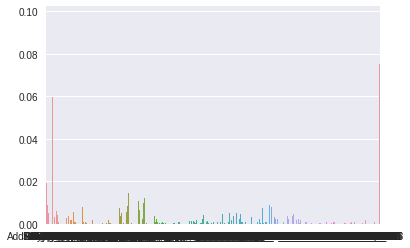

In [44]:
# Zipping feature importances and sorting by how importnat they are
importances = list(zip(train.columns,model.feature_importances_))
#importances = list(zip(best_features,model.feature_importances_))
importances.sort(key=lambda a: a[1])
importances = importances[::-1]
# std = np.std([model.feature_importances_ for tree in model.estimators_],
#              axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(0, len(importances)):
    print("{}: {}".format(importances[f][0], importances[f][1]))

# Plot the feature importances of the forest
sns.barplot(x=train.columns, y=model.feature_importances_)


In [47]:
best_features = [ x[0] for x in list(filter(lambda a : a[1] >0, importances))]

In [48]:
best_features

['Latitude',
 'Longitude',
 'AddressAccuracy',
 'Lat_int',
 'Long_int',
 'Tmax_x',
 'month',
 'Tmin_x',
 'year',
 'WetBulb_x',
 'Heat_x',
 'Tavg_x',
 'SnowFall_x',
 'day',
 'Cool_y',
 'Sunset_x',
 'Depart_x',
 'PrecipTotal_x',
 'DewPoint_x',
 'Depth_x',
 'SeaLevel_x',
 'TSRA_x',
 'Cool_x',
 'FU_x',
 'HZ_x',
 'GR_x',
 'ResultDir_x',
 'Tavg_y',
 'Tmax_x_day_2',
 'Tmin_y',
 'RA_x',
 'SN_x',
 'MIFG_x',
 'ResultSpeed_x',
 'DZ_y',
 'TS_x',
 'TSRA_x_day_2',
 'HZ_x_day_2',
 'FU_y',
 'DewPoint_y',
 'BR_x',
 'TS_y',
 'Tavg_y_day_2',
 'FU_x_day_2',
 'GR_y',
 'AvgSpeed_y',
 'BCFG_x',
 'BR_x_day_2',
 'VCTS_x',
 'MIFG_x_day_2',
 'VCFG_x',
 'AvgSpeed_x_day_2',
 'BCFG_y',
 'FG+_y',
 'TSRA_y',
 'FG_x',
 'Sunrise_x_day_2',
 'DewPoint_x_day_2',
 'VCTS_y_day_2',
 'AvgSpeed_x',
 'RA_y',
 'SeaLevel_x_day_2',
 'PrecipTotal_y',
 'AvgSpeed_x_day_3',
 'VCFG_y',
 'HZ_y',
 'Tmax_y',
 'DZ_x',
 'ResultSpeed_y',
 'Heat_y',
 'ResultSpeed_x_day_3',
 'StnPressure_x',
 'Depth_x_day_2',
 'ResultDir_y',
 'Sunrise_x',
 'Av

In [38]:
train[best_features]

,Longitude,Latitude,Sunrise_x,year,ResultSpeed_x,DewPoint_x,ResultSpeed_y,day,ResultDir_x,ResultDir_y,...,BR_y_day_2,TS_x_day_2,TSRA_x_day_2,HZ_x_day_2,BR_x_day_2,VCTS_y,TSRA_y,MIFG_x,TS_x,Lat_int
0,-87.800991,41.954690,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
1,-87.800991,41.954690,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
2,-87.769279,41.994991,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
3,-87.824812,41.974089,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
4,-87.824812,41.974089,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
5,-87.666455,41.921600,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
6,-87.654491,41.891118,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
7,-87.654224,41.867108,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
8,-87.654224,41.867108,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
9,-87.655232,41.896282,421,2007,4.8,47,4.7,29,10,8,...,0,0,0,0,0,0,0,0,0,41
